In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from Models import probitModel, logisticModel
from util import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import *
from imblearn.over_sampling import SMOTE

In [2]:
SEED = 1

data_folder = 'data'
df = pd.read_csv(os.path.join(data_folder,'mimiciv_traindata.csv'))
df.head()

,Fraction inspired oxygen_mean,Fraction inspired oxygen_min,Fraction inspired oxygen_max,Glucose_mean,Glucose_min,Glucose_max,Heart Rate_mean,Heart Rate_min,Heart Rate_max,Mean blood pressure_mean,...,Temperature_mean,Temperature_min,Temperature_max,Weight_mean,Weight_min,Weight_max,pH_mean,pH_min,pH_max,mortality
0,0.484615,0.4,0.6,155.181818,52.0,280.0,52.367347,35.0,93.0,87.096154,...,36.356349,35.200000,37.100000,81.419764,81.419764,81.419764,7.328750,7.19,7.40,1.0
1,0.600000,0.5,1.0,127.954545,85.0,177.0,72.660377,58.0,105.0,72.315789,...,36.786325,36.388889,37.055556,93.103510,91.807021,95.000000,7.377143,7.34,7.42,0.0
2,0.481250,0.4,0.8,145.625000,116.0,180.0,107.260000,96.0,118.0,86.462963,...,37.316239,36.611111,37.944444,67.500000,67.500000,67.500000,7.372000,7.29,7.45,0.0
3,0.400000,0.4,0.4,100.142857,77.0,154.0,57.250000,47.0,65.0,69.762712,...,NaN,NaN,NaN,80.403091,76.838485,86.000000,7.161250,6.00,7.36,1.0
4,0.566667,0.4,1.0,138.000000,116.0,155.0,84.015625,64.0,114.0,70.662162,...,36.148990,34.722222,37.666667,NaN,NaN,NaN,7.374444,7.27,7.42,1.0


mortality
0.0    0.749424
1.0    0.250576
Name: proportion, dtype: float64


<Axes: xlabel='mortality'>

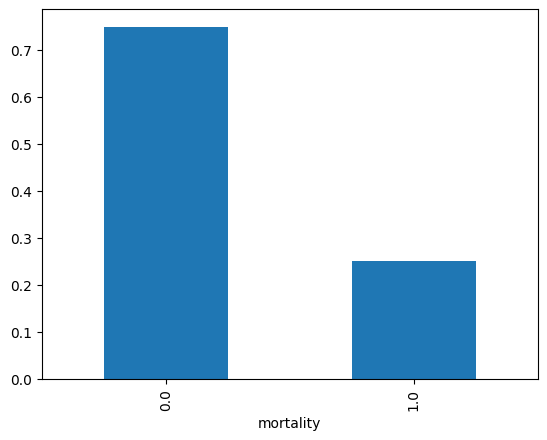

In [3]:
print(df.mortality.value_counts(normalize=True))
df.mortality.value_counts(normalize=True).plot(kind='bar')
#sns.countplot(x='mortality', data=df)

In [4]:
x = df.drop('mortality',axis=1)
y = df.mortality.values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=SEED)

In [5]:
#scaler = RobustScaler(unit_variance=True)
#scaler = QuantileTransformer(output_distribution='normal', ignore_implicit_zeros=False)
scaler = PowerTransformer(method='yeo-johnson', standardize=True)

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

imp = KNNImputer(missing_values=np.nan, n_neighbors=10)#SimpleImputer(missing_values=np.nan, strategy='mean') #
x_train = imp.fit_transform(x_train)
x_test = imp.transform(x_test)

#smote = SMOTE(random_state = SEED)
#print('Original Dataset Shape:', np.unique(y_train, return_counts=True))
#x_train, y_train = smote.fit_resample(x_train, y_train)
#print('Resampled Dataset Shape:', np.unique(y_train, return_counts=True))
n_samples = x.shape[0]
_, (n_samples0, n_samples1) = np.unique(y, return_counts=True)
w0 =  n_samples1/n_samples #n_samples/(2*n_samples0) #
w1 =  n_samples0/n_samples#n_samples/(2*n_samples1) #
print(n_samples, n_samples0, n_samples1)
print(w0,w1)

5647 4232 1415
0.25057552682840445 0.7494244731715956


In [6]:
probit = probitModel(l2=0.05, w=w1)
result, loss_values = probit.fit(x_train, y_train, verbose=True)
print("Optimized parameters (b):", result.x)

Current loss: 0.5062940939006467
Current loss: 0.49460900317365114
Current loss: 0.49063964426234424
Current loss: 0.48984446487098215
Current loss: 0.48965967707893754
Current loss: 0.4895993542820577
Current loss: 0.4895825690382619
Current loss: 0.48957511262977715
Current loss: 0.48957291355327015
Current loss: 0.48957241084723024
Current loss: 0.48957227585272434
Current loss: 0.4895722318008086
Current loss: 0.4895722215542578
Current loss: 0.4895722180850046
Current loss: 0.4895722164162549
Current loss: 0.48957221594220424
Optimized parameters (b): [ 8.10837106e-03  5.11180777e-02 -6.35572584e-02  3.58488539e-02
  8.45672079e-03  2.32705540e-02  5.48504409e-02  2.22474362e-02
  9.58072550e-02 -1.00305462e-02 -1.94582786e-04  1.04367720e-02
 -5.31453011e-02 -2.15596483e-02 -9.30156266e-03 -4.45192421e-02
 -3.95100578e-02  3.44994989e-02 -1.82890981e-02 -3.07009649e-02
 -9.92032367e-06  1.07246461e-01 -4.47910697e-02  1.45549740e-02
 -7.86732926e-02 -7.65715796e-02  2.37417300e-0

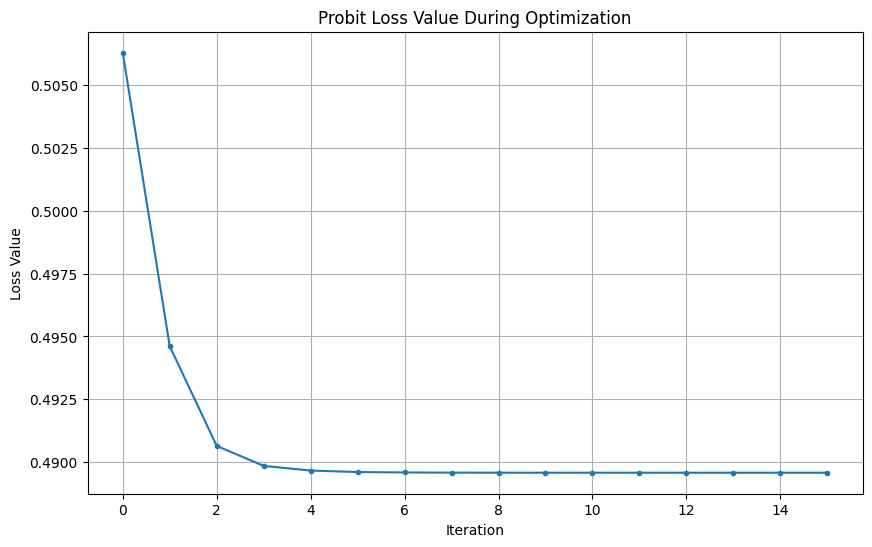

In [7]:
# Plot the loss values after optimization
plt.figure(figsize=(10, 6))
plt.plot(loss_values, marker='.', linestyle='-')
plt.title('Probit Loss Value During Optimization')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid()
plt.show()

Accuracy: 0.644
Precision: 0.393
Recall: 0.601
F1 Score: 0.475
AUC score: 0.672 



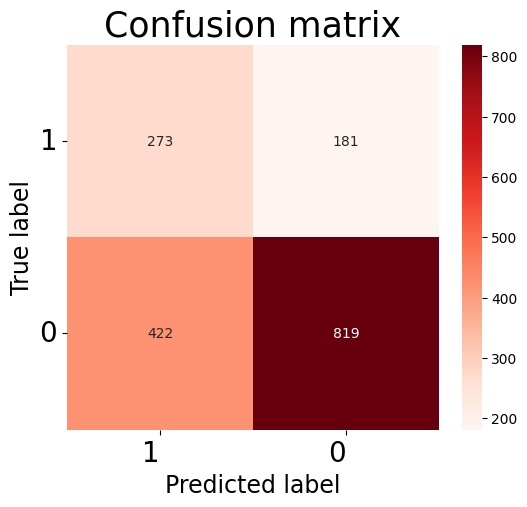

In [8]:
y_prob = probit.predict_proba(x_test)[:,1]
y_label = probit.predict(x_test)
evaluate_model(y_test, y_label, y_prob)

Optimal threshold is 0.5051, at f1 score of 0.4774


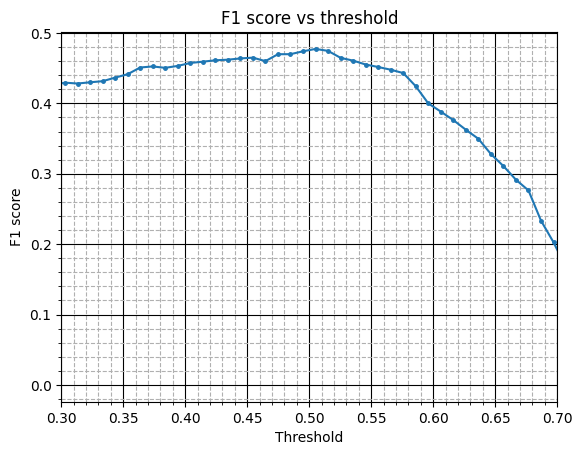

In [9]:
plot_f1_vs_thr(y_test, y_prob)

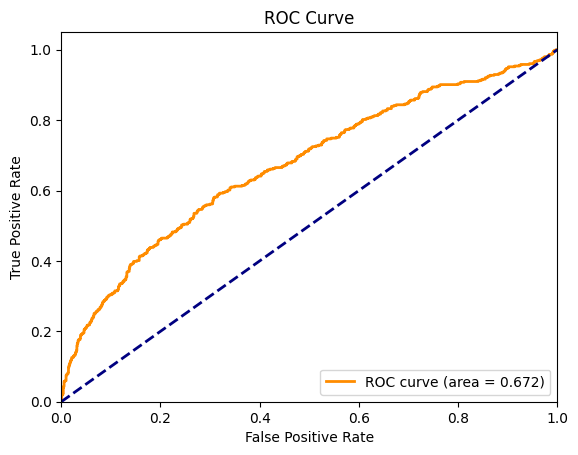

In [10]:
plot_roc(y_test, y_prob)

In [11]:
logit = logisticModel(l2=0.0, w=w1)
result, loss_values = logit.fit(x_train, y_train, verbose=True)
print("Optimized parameters (b):", result.x)

Current loss: 0.49169733909723495
Current loss: 0.4818925096819403
Current loss: 0.4784929221296645
Current loss: 0.47580366050046397
Current loss: 0.47408739046260545
Current loss: 0.4730944087914044
Current loss: 0.4725782348349942
Current loss: 0.4722446295864293
Current loss: 0.47195889672872227
Current loss: 0.471682178752968
Current loss: 0.4714443672766885
Current loss: 0.47124864612589823
Current loss: 0.4710650882156815
Current loss: 0.47086400543573464
Current loss: 0.4706467686894984
Current loss: 0.47045081728295357
Current loss: 0.4703053073774988
Current loss: 0.47019541856929586
Current loss: 0.4700908809553655
Current loss: 0.469982797948219
Current loss: 0.4698860322048885
Current loss: 0.46981296594400557
Current loss: 0.4697625621087422
Current loss: 0.4697289361632048
Current loss: 0.4697066709355148
Current loss: 0.46968950426295675
Current loss: 0.4696725865737404
Current loss: 0.4696548130772695
Current loss: 0.46963761244400387
Current loss: 0.4696213613232333
C

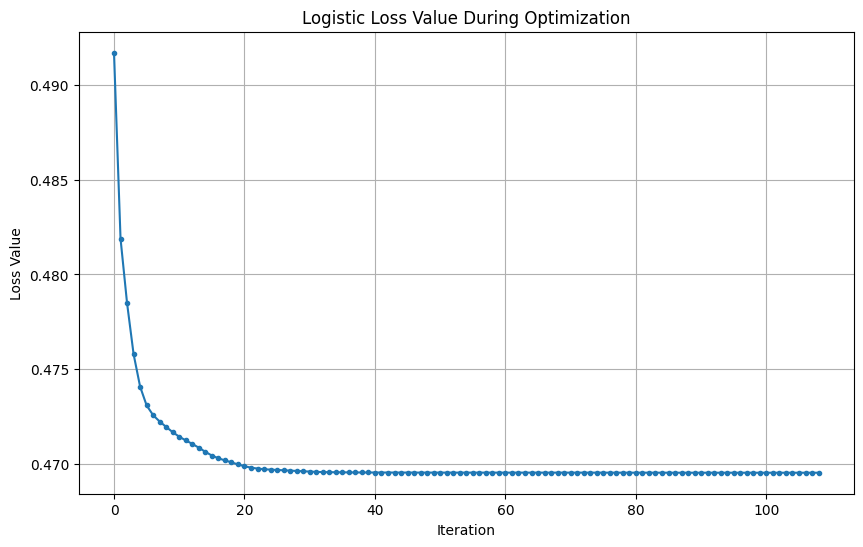

In [12]:
# Plot the loss values after optimization
plt.figure(figsize=(10, 6))
plt.plot(loss_values, marker='.', linestyle='-')
plt.title('Logistic Loss Value During Optimization')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid()
plt.show()

Accuracy: 0.653
Precision: 0.398
Recall: 0.579
F1 Score: 0.472
AUC score: 0.674 



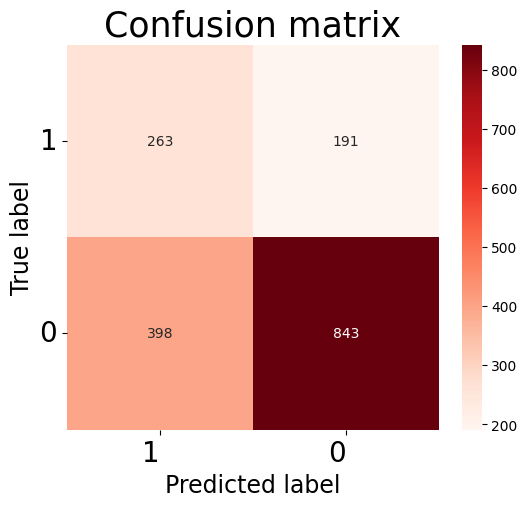

In [13]:
y_prob = logit.predict_proba(x_test)[:,1]
y_label = logit.predict(x_test)
evaluate_model(y_test, y_label, y_prob)

Optimal threshold is 0.4747, at f1 score of 0.4743


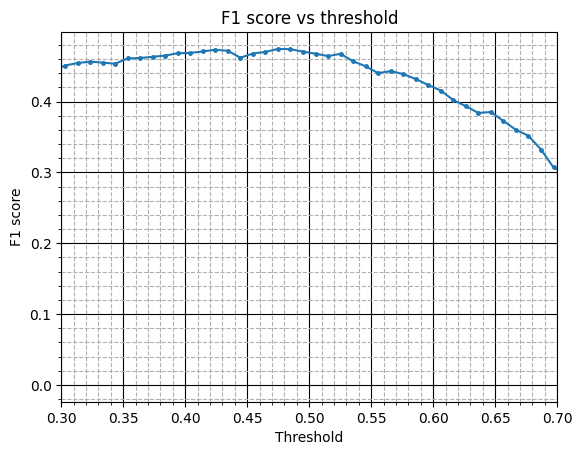

In [14]:
plot_f1_vs_thr(y_test, y_prob)

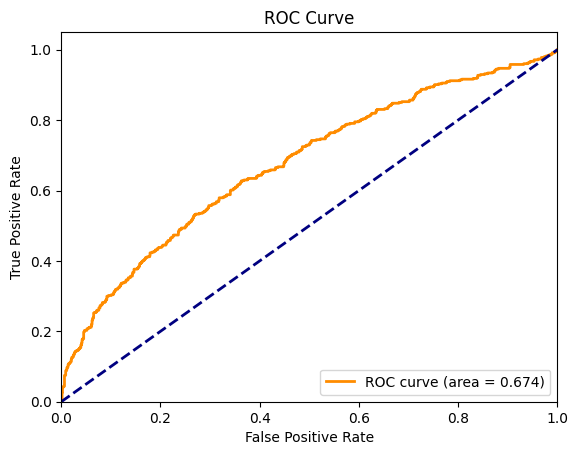

In [15]:
plot_roc(y_test, y_prob)

In [16]:
from sklearn.linear_model import LogisticRegression


model = LogisticRegression(fit_intercept=True, solver='newton-cg')
model.fit(x_train, y_train)
b_sklearn = model.coef_[0]  # Weights (b)
bias_sklearn = model.intercept_[0]  # Bias term


In [17]:
from sklearn.metrics import log_loss

log_loss(y_test, model.predict_proba(x_test))

0.5450982238609953

Accuracy: 0.749
Precision: 0.667
Recall: 0.123
F1 Score: 0.208
AUC score: 0.676 



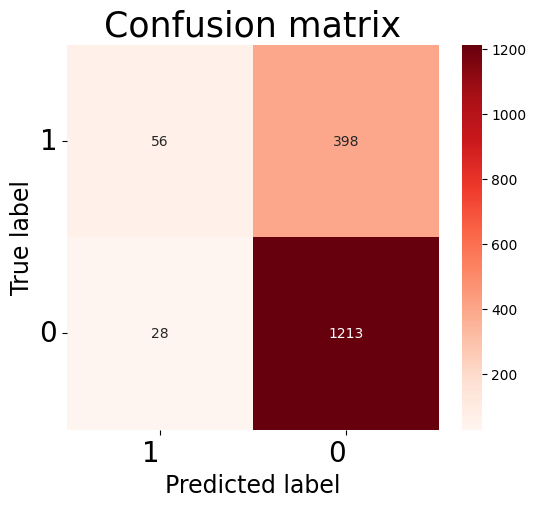

In [18]:
y_prob = model.predict_proba(x_test)[:,1]
y_label = model.predict(x_test)
evaluate_model(y_test, y_label, y_prob)

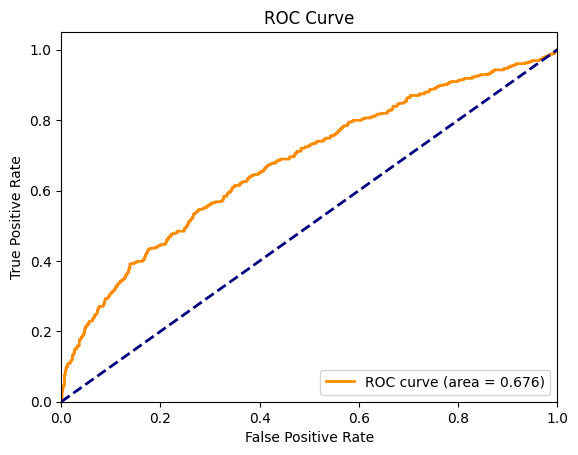

In [19]:
plot_roc(y_test, y_prob)